In [ ]:
import json
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline


# Prepare & Configure Data 

## Collect latest data from GitHub

In [ ]:
url = 'https://raw.githubusercontent.com/Princeton-CDH/pemm-data/master/data/story_instance.csv'
df_s = pd.read_csv(url)

In [ ]:
OUTPUT_DIR = 'output'
DATA_STRUCTURE_DIR = os.path.join(OUTPUT_DIR, 'data_structures')
PLOT_DIR = os.path.join(OUTPUT_DIR, 'all_plots')
SEQUENCE_DIR = os.path.join(OUTPUT_DIR, 'sequence_data')

if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)
if not os.path.exists(DATA_STRUCTURE_DIR):
    os.makedirs(DATA_STRUCTURE_DIR)
if not os.path.exists(SEQUENCE_DIR):
    os.makedirs(SEQUENCE_DIR)

## Clean data

### Drop unnecessary columns and rows

In [ ]:
print(f'Original number of rows: {df_s.shape[0]}')
df_s = df_s[['Manuscript', 'Canonical Story ID', 'Miracle Number', 'Canonical Story Title']]
df_s = df_s.dropna()
print(f'New number of rows after NaNs dropped: {df_s.shape[0]}')

Original number of rows: 10298
New number of rows after NaNs dropped: 4604


### Create an Integer ID column and mapper

Parsing and sorting the strings in `Canonical Story ID` is difficult because of their naming convention. Here we develop a continuous, unique integer ID that is useful for analysis

In [ ]:
# create an integer ID that is easier than Canonical Story ID to sort and parse
sorted_strings = sorted(df_s['Canonical Story ID'].unique().tolist())
sorted_ints = sorted(sorted_strings, key=lambda x: int(x.split('-')[0]) if 'L' not in x else 600)
int_id_mapper = {s: i for i, s in enumerate(sorted_ints)}
reverse_id_mapper = {s: i for i, s in int_id_mapper.items()}

df_s['Integer ID'] = df_s['Canonical Story ID'].apply(lambda x: int_id_mapper[x]).astype('int64')
df_s.sample(5)

,Manuscript,Canonical Story ID,Miracle Number,Canonical Story Title,Integer ID
7813,EMML (HMML) 7543,81,81.0,"A Muslim, Katib, tries to extort money from th...",88
2366,C-Berlin (BS) 1,54,9.0,Saint Mary carries a dying monk to Jerusalem.,61
4843,EMML (HMML) 2275,137,27.0,The Emperor of Rome who erected an altar in hi...,144
10216,Z-Paris (BNF) 62,42,36.0,The church built on the tomb of Saint Mary tha...,49
7944,EMML (HMML) 7543,210,212.0,Thecla cycle: Thecla is taken to Alexandria to...,218


In [ ]:
df_t = pd.DataFrame([[k, v] for (k, v) in int_id_mapper.items()], columns=['Canonical Story ID', 'Integer ID'])
df_t.to_csv(os.path.join(DATA_STRUCTURE_DIR, 'integer-id-mapper.csv'), index=False)

## Transform table into list of lists

A useful data structure in the following form:

```
all_manuscripts = [
    [1, 2, 3, ...],
    [1, 2, 3, 4, 5, ...],
    [2, 1, 4, 5, 10, 15, ...],
    [10, 2, 4, 5, 6, 3, 7, ...],
    [8, 9, 11, 2, 1, ...],
    [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, ...], 
    [11, 2, 12, 8, 13, 15, 14, ...]
]
```

In [ ]:
all_manuscripts = []
all_manuscript_names = []
for i, df in df_s.groupby('Manuscript'):
    df = df.sort_values('Miracle Number')
    all_manuscripts.append(df['Integer ID'].tolist())
    all_manuscript_names.append(df['Manuscript'].unique()[0])

In [ ]:
with open(os.path.join(DATA_STRUCTURE_DIR, 'all-manuscripts.json'), 'w') as f:
    json.dump(all_manuscripts, f, indent=4)

## Create other constants & data structures

In [ ]:
all_ids = []
for man in all_manuscripts:
    all_ids.extend(man)

N = max(all_ids)
unique_ids = set(all_ids)

---
# Analyze Data

## How many story instances are in each manuscript?

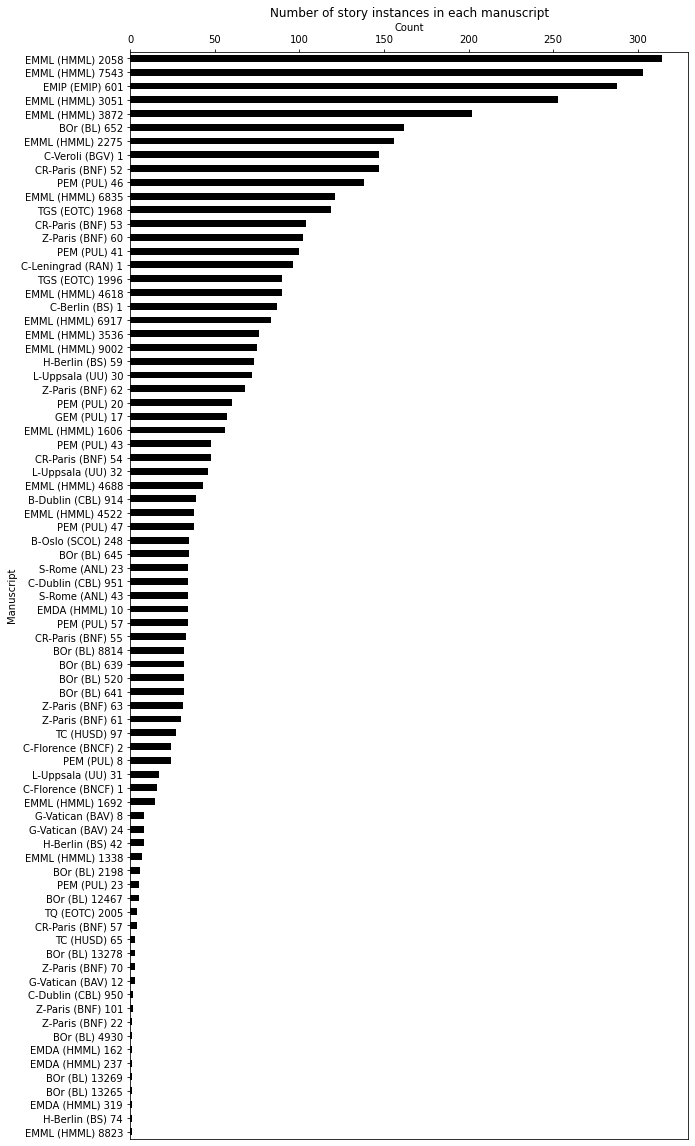

In [ ]:
ax = (
    df_s.groupby('Manuscript')['Integer ID']
        .count()
        .sort_values()
        .plot(kind='barh', figsize=(10, 20), color='k')
)

ax.set_title('Number of story instances in each manuscript')
ax.set_ylabel('Manuscript')
ax.set_xlabel('Count')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

plt.savefig(os.path.join(PLOT_DIR, 'story-instances-per-manuscript.png'))

## How often does each Story ID appear?

In [ ]:
def get_story_name(df, story_id):
    return df[df['Canonical Story ID'] == story_id]['Canonical Story Title'].unique().tolist()[0]

popular_stories = df_s['Canonical Story ID'].value_counts()[:10]

print('Top 10 Most Frequent Stories\n')
for i, (story_id, count) in enumerate(popular_stories.iteritems()):
    story_name = get_story_name(df_s, story_id)
    print(f'\t#{i+1}\n\tStory ID: {story_id}\n\tCount: {count}\n\t{story_name}\n')

Top 10 Most Frequent Stories

	#1
	Story ID: 142
	Count: 58
	The deacon's prayer that contained five times "Rejoice!" [tafassehiyat].

	#2
	Story ID: 140
	Count: 51
	The sinful deacon whom his enemies could not kill until he had confessed himself to a priest.

	#3
	Story ID: 163
	Count: 51
	The Muslim whom Saint Mary told to receive baptism. Later, as Bishop of Rome, he cut off his hand because of a carnal thought.

	#4
	Story ID: 13
	Count: 50
	The composition of the Miracles of Mary by Bishop Hildephonsus of Toledo.

	#5
	Story ID: 154
	Count: 48
	The two women who were attacked by robbers on their way to church.

	#6
	Story ID: 153
	Count: 47
	The young man who used to bring roses to the icon of Saint Mary.

	#7
	Story ID: 125
	Count: 47
	The story of the cannibal from Qemer.

	#8
	Story ID: 187
	Count: 47
	The peasant who complained to Saint Mary because she did not reply to his Hail Mary.

	#9
	Story ID: 162
	Count: 45
	The pious monk scribe who used to write Saint Mary's name in 

In [ ]:
df_t.head()

,Canonical Story ID,Integer ID
142,58,150
140,51,147
163,51,171
13,50,14
154,48,162


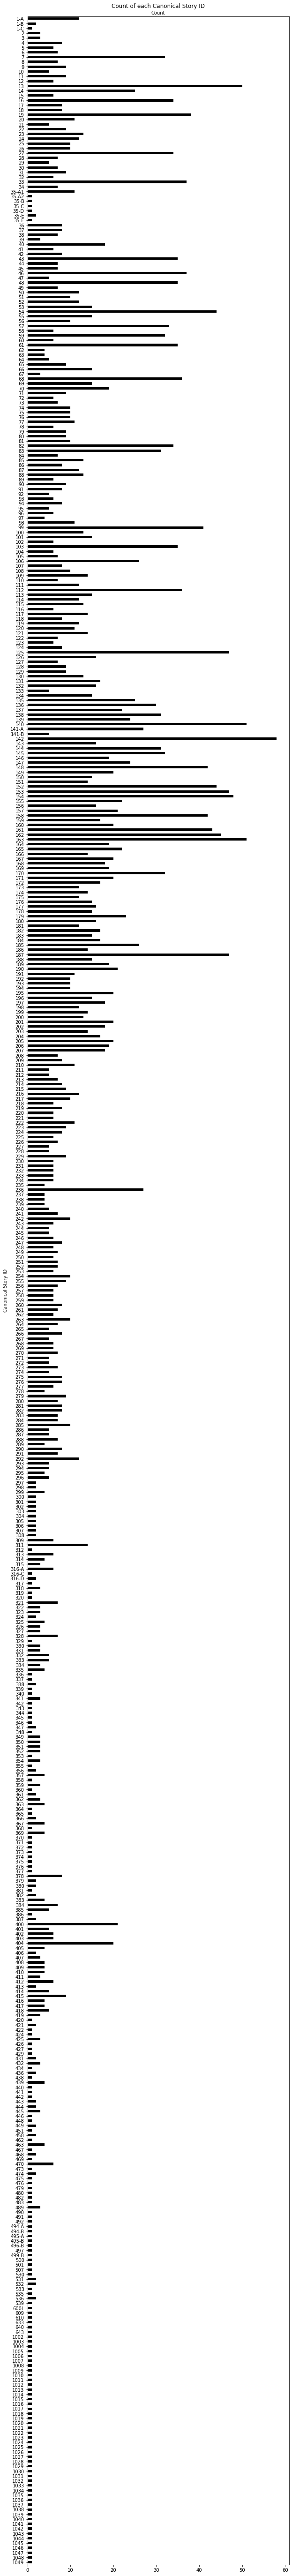

In [ ]:
m = df_s['Canonical Story ID'].value_counts()

# NOTE: Pandas does not support custom sort functions, so a separate dataframe was necessary
df_t = pd.DataFrame(m)
df_t['t'] = df_t.index
df_t['Integer ID'] = df_t['t'].apply(lambda x: int_id_mapper[x])
df_t = df_t[['Canonical Story ID', 'Integer ID']]

ax = (
    df_t
        .sort_values(by='Integer ID') # to sort by Integer ID uncomment this line
        ['Canonical Story ID']
        .plot(kind='barh', color='k', figsize=(10, 100))
)

ax.set_title('Count of each Canonical Story ID')
ax.set_xlabel('Count')
ax.xaxis.tick_top
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Canonical Story ID')
ax.invert_yaxis()
plt.savefig(os.path.join(PLOT_DIR, 'canonical-story-id-count.png'))

## What are the Levenshtein edit distances between manuscripts?

[Learn more about the  Levenshtein edit distance](https://en.wikipedia.org/wiki/Levenshtein_distance)

In [ ]:
def levenshteinDistance(s1, s2):
    # this was copy-and-pasted from stack overflow, better review is needed
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [ ]:
ld = [[levenshteinDistance(man1, man2) for man2 in all_manuscripts] for man1 in all_manuscripts]

In [ ]:
# First create a static image
axes = [all_manuscript_names[i] for i, x in enumerate(all_manuscripts)]
df_ld = pd.DataFrame(ld, columns=axes, index=axes)
plt.figure(figsize=(35, 35))

plt.pcolor(df_ld)
        
plt.colorbar()
plt.yticks(np.arange(0.5, df_ld.shape[0], 1), axes)
plt.gca().invert_yaxis()

plt.xticks(np.arange(0.5, df_ld.shape[0], 1), axes, rotation=90)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top') 

plt.title('Levenhshtein edit distance between manuscripts')
plt.savefig(os.path.join(PLOT_DIR, 'levenhshtein-heatmap.png'))
# this plot is not shown
plt.close()

# Create a dynamic image with hover
# The y-axis is inverted manually because plotly has no straightforward way to 
#  invert the y axis or place the x-axis on top.
ld_r = list(reversed(ld))
axes = [all_manuscript_names[i] for i, x in enumerate(all_manuscripts)]

fig = px.imshow(ld_r, width=1300, height=1300, title="Levenhshtein edit distance between manuscripts")
fig.update_xaxes(tickangle=90, tickmode='array', ticktext=axes, tickvals=list(range(len(axes))))
fig.update_yaxes(tickmode='array', ticktext=axes, tickvals=list(reversed(range(len(axes)))))

## Story ID's neighbors
A colocation json is created to analyze a story ID's most frequent neighbors

In [ ]:
neighbor_d = {x: {'before': [], 'after': []} for x in unique_ids}
for man in all_manuscripts:
    for i, story_id in enumerate(man):
        if i == 0:
            neighbor_d[story_id]['before'].append('F')
            if len(man) != 1:
                neighbor_d[story_id]['after'].append(man[i+1])
            else:
                neighbor_d[story_id]['after'].append('L')
        elif i == len(man)-1:
            neighbor_d[story_id]['before'].append(man[i-1])
            neighbor_d[story_id]['after'].append('L')
        else:
            neighbor_d[story_id]['before'].append(man[i-1])
            neighbor_d[story_id]['after'].append(man[i+1])

with open(os.path.join(SEQUENCE_DIR, 'collocation.json'), 'w') as f:
    json.dump(neighbor_d, f)

### What IDs are most commonly first and last in a manuscript?

In [ ]:
first_count = []
for x, d in neighbor_d.items():
    first_count.append([x, d['before'].count('F')])
df_fc = pd.DataFrame(first_count, columns=['ID', 'Count'])
df_fc['Canonical Story ID'] = df_fc['ID'].apply(lambda x: reverse_id_mapper[x])
df_fc = df_fc.sort_values('Count', ascending=False) 

df_fc = df_fc[df_fc['Count'] > 1]
df_fc['Canonical Story Title'] = df_fc['Canonical Story ID'].apply(lambda x: get_story_name(df_s, x))

print('Stories that appear first more than once:')
for i,(_, r) in enumerate(df_fc.iterrows()):
    print(f"\t#{i+1}\n\tStory ID: {r['Canonical Story ID']}\n\tCount: {r['Count']}\n\t{r['Canonical Story Title']}\n")

Stories that appear first more than once:
	#1
	Story ID: 13
	Count: 37
	The composition of the Miracles of Mary by Bishop Hildephonsus of Toledo.

	#2
	Story ID: 14
	Count: 4
	The composition of the Wǝddāse Maryam by the Syrian potter.

	#3
	Story ID: 207
	Count: 4
	The monk who saved the church of Saint Mary in Atrib by his prayers when its destruction had been ordered by the Caliph.

	#4
	Story ID: 106
	Count: 3
	The rich man who threw dry bread to a beggar in the name of Saint Mary.

	#5
	Story ID: 400
	Count: 3
	The five sorrows of Saint Mary.

	#6
	Story ID: 489
	Count: 2
	Ark of Zion cycle: The beginning of the history of the Ark of Zion in the giving of the Ten Commandments.

	#7
	Story ID: 187
	Count: 2
	The peasant who complained to Saint Mary because she did not reply to his Hail Mary.



In [ ]:
last_count = []
for x, d in neighbor_d.items():
    last_count.append([x, d['after'].count('L')])
df_lc = pd.DataFrame(last_count, columns=['ID', 'Count'])
df_lc['Canonical Story ID'] = df_lc['ID'].apply(lambda x: reverse_id_mapper[x])
df_lc = df_lc.sort_values('Count', ascending=False) 

df_lc = df_lc[df_lc['Count'] > 1]
df_lc['Canonical Story Title'] = df_lc['Canonical Story ID'].apply(lambda x: get_story_name(df_s, x))

print('Stories that appear last more than once:\n')
for i,(_, r) in enumerate(df_lc.iterrows()):
    print(f"\t#{i+1}\n\tCanonical Story ID: {r['Canonical Story ID']}\n\tCount: {r['Count']}\n\t{r['Canonical Story Title']}\n")

Stories that appear last more than once:

	#1
	Canonical Story ID: 236
	Count: 5
	Saint Mary gives a thirsty dog water to drink from her shoe.

	#2
	Canonical Story ID: 400
	Count: 5
	The five sorrows of Saint Mary.

	#3
	Canonical Story ID: 125
	Count: 3
	The story of the cannibal from Qemer.

	#4
	Canonical Story ID: 292
	Count: 3
	Däbrä Metmaq miracles: Saint Mary shows those assembled at Däbrä Metmaq a negative vision of Mohammad

	#5
	Canonical Story ID: 54
	Count: 2
	Saint Mary carries a dying monk to Jerusalem.

	#6
	Canonical Story ID: 148
	Count: 2
	The pregnant woman who was caught by the tide while going to the church of Saint Michael (Mont Saint Michel)

	#7
	Canonical Story ID: 309
	Count: 2
	Saint Mary appears to an official who kidnapped a girl that had made a vow of virginity.

	#8
	Canonical Story ID: 311
	Count: 2
	A stream runs uphill after his neighbor had diverted it.

	#9
	Canonical Story ID: 14
	Count: 2
	The composition of the Wǝddāse Maryam by the Syrian potter

### Collocation matrices
Percent of time an ID precedes or follows another story. 

In [ ]:
def perc(map_dict, i, c):
    l = map_dict.get(i, [])
    return np.nan if len(l) == 0 else round(l.count(c)/len(l)*100, 2)

before_map = {x: d['before'] for x, d in neighbor_d.items()}
after_map = {x: d['after'] for x, d in neighbor_d.items()}

df_b = pd.DataFrame(columns=['F'] + list(range(N)), index=range(N))
for c in df_b.columns:
    df_b[c] = [perc(before_map, i, c) for i in df_b.index]

df_a = pd.DataFrame(columns=list(range(N)) + ['L'], index=range(N))
for c in df_a.columns:
    df_a[c] = [perc(after_map, i, c) for i in df_a.index]

In [ ]:
df_b.to_csv(os.path.join(SEQUENCE_DIR, 'collocation-before.csv'), index=False)
df_a.to_csv(os.path.join(SEQUENCE_DIR, 'collocation-after.csv'), index=False)

## What are the most popular sequences of length K?

Use the integer IDs to create a dictionary of the form ```{"#-#-#-...": count}```

Then convert to the Canonical IDs and create a table from the dictionary.

In [ ]:
K = 10

In [ ]:
sequence_count = {}
for man in all_manuscripts:
    if len(man) > K:
        for i, story_id in enumerate(man[:-K]):
            seq = man[i:i+K]
            assert len(seq) == K, "Something's gone wrong"
            seq_string = '-'.join([str(x) for x in seq])
            sequence_count[seq_string] = sequence_count.get(seq_string, 0) + 1
    elif len(man) == K:
        seq = man
        seq_string = '-'.join([str(x) for x in seq])
        sequence_count[seq_string] = sequence_count.get(seq_string, 0) + 1

sequence_count_list = [[[reverse_id_mapper[int(x)] for x in seq.split('-')], c] for seq, c in sequence_count.items()]

df_sc = pd.DataFrame(sequence_count_list, columns=['Sequence', 'Count'])
df_sc = df_sc.sort_values('Count', ascending=False)
df_sc.to_csv(os.path.join(SEQUENCE_DIR, f'{K}-gram-count.csv'))
df_sc.head(15)

,Sequence,Count
35,"[33, 54, 153, 154, 16, 46, 43, 48, 59, 57]",24
33,"[19, 27, 33, 54, 153, 154, 16, 46, 43, 48]",23
10,"[43, 48, 59, 57, 61, 68, 82, 83, 99, 103]",23
34,"[27, 33, 54, 153, 154, 16, 46, 43, 48, 59]",23
36,"[54, 153, 154, 16, 46, 43, 48, 59, 57, 61]",23
9,"[46, 43, 48, 59, 57, 61, 68, 82, 83, 99]",23
15,"[68, 82, 83, 99, 103, 112, 158, 140, 142, 7]",22
13,"[57, 61, 68, 82, 83, 99, 103, 112, 158, 140]",22
12,"[59, 57, 61, 68, 82, 83, 99, 103, 112, 158]",22
11,"[48, 59, 57, 61, 68, 82, 83, 99, 103, 112]",22


## Where does each story fall within the manuscript?

In [ ]:
BINS = 10
STORY_THRESHOLD = 5
MANUSCRIPT_THRESHOLD = 5

In [ ]:
story_location = {}
for man in all_manuscripts:
    if len(man) > MANUSCRIPT_THRESHOLD:
        for i, story_id in enumerate(man):
            l = story_location.get(story_id, [])
            l.append(i / len(man)*100)
            story_location[story_id] = l

In [ ]:
# filter out stories that don't occur too often
story_location = {s: l for s, l in story_location.items() if len(l) > STORY_THRESHOLD}

In [ ]:
story_location_hist = [[story_id, plt.hist(l, bins=BINS)[0].tolist()] for story_id, l in story_location.items()]
plt.close()

In [ ]:
# sort by the Integer ID
story_location_hist = sorted(story_location_hist, key=lambda x: x[0])
# get only the values
story_location_hist_vals = [x[1] for x in story_location_hist]
story_location_int_ids = [x[0] for x in story_location_hist]
# use percentages instead of raw count
story_location_hist_vals = [[t/sum(x)*100 for t in x] for x in story_location_hist_vals]
df_sl = pd.DataFrame(story_location_hist_vals, index=[reverse_id_mapper[x] for x in story_location_int_ids], columns=range(0, 100, 10))
df_sl.head(10)

,0,10,20,30,40,50,60,70,80,90
1-A,33.333333,0.000000,0.00,8.333333,0.000000,0.00,16.666667,16.666667,0.000000,25.000000
4,37.500000,0.000000,12.50,0.000000,0.000000,0.00,0.000000,12.500000,25.000000,12.500000
5,50.000000,0.000000,0.00,0.000000,16.666667,0.00,0.000000,16.666667,0.000000,16.666667
6,42.857143,0.000000,0.00,0.000000,14.285714,0.00,14.285714,0.000000,14.285714,14.285714
7,12.500000,3.125000,6.25,3.125000,3.125000,6.25,12.500000,6.250000,15.625000,31.250000
8,42.857143,0.000000,0.00,0.000000,14.285714,0.00,14.285714,0.000000,14.285714,14.285714
9,33.333333,11.111111,0.00,11.111111,11.111111,0.00,0.000000,0.000000,11.111111,22.222222
11,33.333333,0.000000,0.00,11.111111,0.000000,0.00,11.111111,22.222222,11.111111,11.111111
12,50.000000,0.000000,0.00,0.000000,0.000000,0.00,16.666667,16.666667,0.000000,16.666667
13,89.795918,4.081633,0.00,0.000000,4.081633,0.00,0.000000,0.000000,0.000000,2.040816


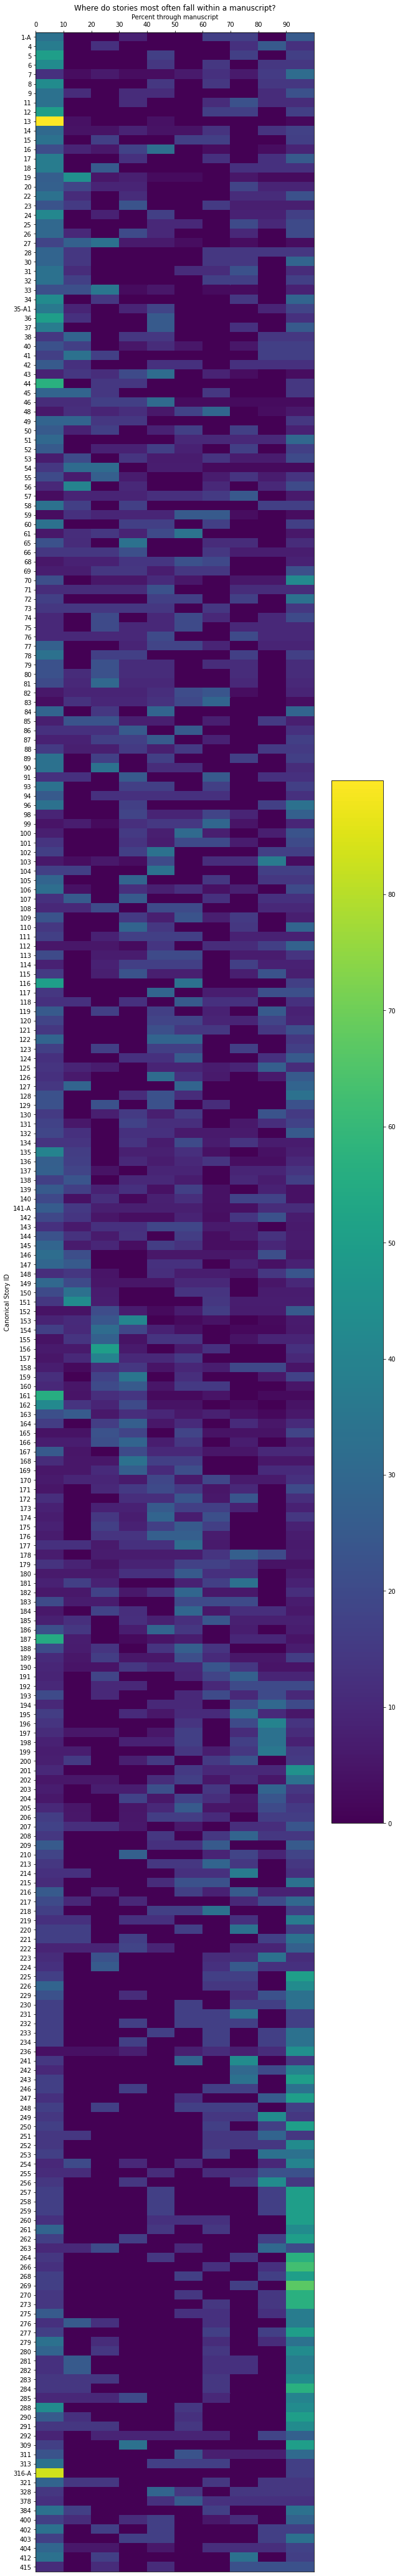

In [ ]:
plt.figure(figsize=(10, 75))
plt.pcolor(df_sl)
plt.yticks(np.arange(0.5, len(df_sl.index), 1), df_sl.index)
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top') 
plt.xticks(np.arange(0, df_sl.shape[1], 1), df_sl.columns)
plt.ylabel('Canonical Story ID')
plt.xlabel('Percent through manuscript')
plt.title('Where do stories most often fall within a manuscript?')
plt.colorbar()
plt.savefig(os.path.join(PLOT_DIR, 'story-placement.png'))
None